### Import librabries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, ConfusionMatrixDisplay


import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Conv2D, Activation,BatchNormalization, MaxPooling2D, Dropout, Flatten, Input
from keras.models import load_model, Sequential, Model
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from keras.utils import np_utils


import cv2

In [ ]:
#for gbu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15961080006387862153
xla_global_id: -1
]


### 1. Read the dataset

#### 1.2 Read labels

In [ ]:
# read labels
df_labels = pd.read_csv('/content/drive/MyDrive/data/Brain/dataset/dataset/label.csv')

df_labels['tumor'] = 1
df_labels['tumor'][df_labels['label'] == 'no_tumor'] = 0

df_labels['tumor_type'] = df_labels['tumor']
df_labels['tumor_type'] = df_labels['label'].map({'no_tumor': 0, 'meningioma_tumor': 1, 'glioma_tumor': 2, 'pituitary_tumor': 3 })


labels = df_labels['tumor']

df_labels.to_csv('p_labels.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
df_labels.head(10)

,file_name,label,tumor,tumor_type
0,IMAGE_0000.jpg,meningioma_tumor,1,1
1,IMAGE_0001.jpg,no_tumor,0,0
2,IMAGE_0002.jpg,meningioma_tumor,1,1
3,IMAGE_0003.jpg,glioma_tumor,1,2
4,IMAGE_0004.jpg,meningioma_tumor,1,1
5,IMAGE_0005.jpg,meningioma_tumor,1,1
6,IMAGE_0006.jpg,no_tumor,0,0
7,IMAGE_0007.jpg,glioma_tumor,1,2
8,IMAGE_0008.jpg,glioma_tumor,1,2
9,IMAGE_0009.jpg,pituitary_tumor,1,3


In [ ]:
df_labels.count()

file_name     3000
label         3000
tumor         3000
tumor_type    3000
dtype: int64

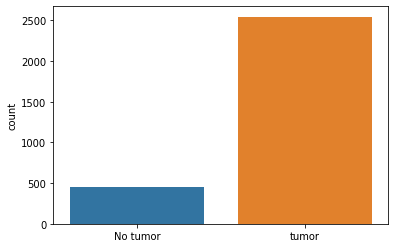

In [ ]:
plt.figure()

sns.color_palette("bright")  
sns.countplot(x='tumor',  data=df_labels)
plt.xticks([0,1], ['No tumor', 'tumor'])
plt.xlabel("")
plt.show()

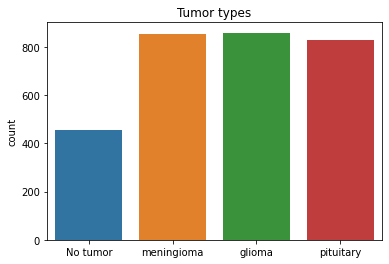

In [ ]:
plt.figure()
sns.countplot(x='tumor_type',  data=df_labels)
plt.xticks([0,1,2,3], ['No tumor', 'meningioma','glioma', 'pituitary'])
plt.xlabel("")
plt.title("Tumor types")
plt.show()

#### 2.2 Read images

In [ ]:
df_labels.head()

,file_name,label,tumor,tumor_type
0,IMAGE_0000.jpg,meningioma_tumor,1,1
1,IMAGE_0001.jpg,no_tumor,0,0
2,IMAGE_0002.jpg,meningioma_tumor,1,1
3,IMAGE_0003.jpg,glioma_tumor,1,2
4,IMAGE_0004.jpg,meningioma_tumor,1,1


In [ ]:
Img_id = df_labels['file_name']

In [ ]:
# "grayscale" for baseline models  "rgb" for cnn
imgs =[np.array(image.load_img('/content/drive/MyDrive/data/Brain/crop/{}'.format(i),target_size=(100,100), color_mode = "rgb"))/255 for i in tqdm(Img_id[:Img_id.size])]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
imgs_arr = np.array(imgs)

In [ ]:
imgs_arr.shape

(3000, 100, 100, 3)

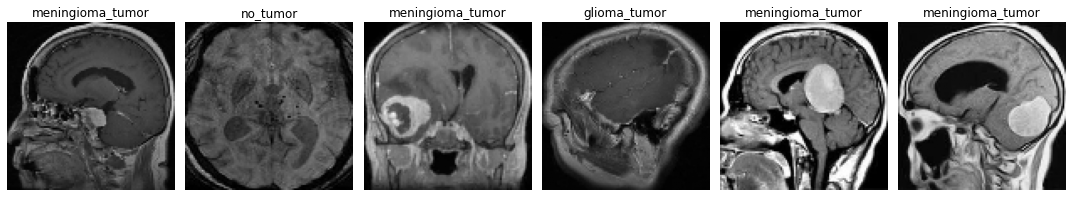

In [ ]:
# show samples
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(imgs_arr[i],cmap='gray')
    plt.title(df_labels.label[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [ ]:
# for grayscale only
#imgs_arr = imgs_arr.reshape(imgs_arr.shape[0], imgs_arr.shape[1], imgs_arr.shape[2], 1)

New code for test dataset

In [ ]:
df_labels_test = pd.read_csv('/content/drive/MyDrive/data/Brain/test_dataset/test/label.csv')


df_labels_test['tumor'] = 1
df_labels_test['tumor'][df_labels_test['label'] == 'no_tumor'] = 0

df_labels_test['tumor_type'] = df_labels_test['tumor']
df_labels_test['tumor_type'] = df_labels_test['label'].map({'no_tumor': 0, 'meningioma_tumor': 1, 'glioma_tumor': 2, 'pituitary_tumor': 3 })

labels_test = df_labels_test['tumor']


Img_id_test = df_labels_test['file_name']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
###### New code for test data

test_imgs =[np.array(image.load_img('/content/drive/MyDrive/data/Brain/test_dataset/test/crop/{}'.format(i),target_size=(100,100), color_mode = "rgb"))/255 for i in tqdm(Img_id_test[:Img_id_test.size])]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
imgs_arr_test = np.array(test_imgs)

##### Crop images

In [ ]:
!pip install imutils

import imutils

In [ ]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [ ]:
os.listdir('/content/drive/MyDrive/data/Brain/test_dataset/test/image')
          '/content/drive/MyDrive/data/Brain/test_dataset/test/crop'

In [ ]:
for file in tqdm(os.listdir('/content/drive/MyDrive/data/Brain/test_dataset/test/image')):
    #print(file)
    ex_img = cv2.imread('/content/drive/MyDrive/data/Brain/test_dataset/test/image/' + file)
    ex_crop_img = crop_brain_contour(ex_img, False)
    filename= '/content/drive/MyDrive/data/Brain/test_dataset/test/crop/'+ file
    print(filename)
    cv2.imwrite(filename,ex_crop_img)

### 2. Baseline models

In [ ]:
#X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
#X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))

New code for test dataset

In [ ]:
X_train_reshaped = imgs_arr.reshape((imgs_arr.shape[0], imgs_arr.shape[1]*imgs_arr.shape[2]*imgs_arr.shape[3]))
X_test_reshaped = imgs_arr_test.reshape((imgs_arr_test.shape[0], imgs_arr_test.shape[1]*imgs_arr_test.shape[2]*imgs_arr_test.shape[3]))

#### 2.1 KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create a k-NN classifier with 5 neighbors: knn
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier to the training data
with tf.device('/gpu:0'):
  knn.fit(X_train_reshaped, labels)

In [ ]:
# Print the accuracy
print("Training accuracy: ", knn.score(X_train_reshaped, labels))

Training accuracy:  0.9453333333333334


In [ ]:
scores = cross_val_score(knn, X_train_reshaped, labels, cv=5)

In [ ]:
scores

array([0.9       , 0.92833333, 0.92166667, 0.895     , 0.93      ])

In [ ]:
print("%0.2f is the cross validation accuracy with 5 folds, with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.92 Cross validation accuracy with 5 folds  with a standard deviation of 0.01


In [ ]:
print("Test accuracy: ", knn.score(X_test_reshaped, labels))

Test accuracy:  0.905


In [ ]:
y_pred = knn.predict(X_test_reshaped)
target_names = ['No tumor', 'Tumor']
print(classification_report(labels, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

    No tumor     0.7368    0.7568    0.7467        37
       Tumor     0.9444    0.9387    0.9415       163

    accuracy                         0.9050       200
   macro avg     0.8406    0.8477    0.8441       200
weighted avg     0.9060    0.9050    0.9055       200



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


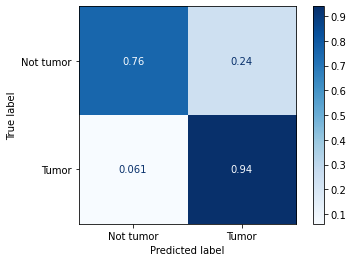

In [ ]:
plot_confusion_matrix(knn, X_test_reshaped, labels, normalize = "true", cmap=plt.cm.Blues, display_labels=['Not tumor', 'Tumor'])  
plt.show()

In [ ]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors = k)

    # Fit the classifier to the training data
    with tf.device('/gpu:0'):
      knn.fit(X_train_reshaped, labels)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train_reshaped, labels)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test_reshaped, df_labels_test.tumor)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

####2.2 SVM

In [ ]:
# SVM
from sklearn.svm import SVC

# Instantiate the SVC classifier: clf
clf = SVC()

# Fit the pipeline to the train set
with tf.device('/gpu:0'):
  clf.fit(X_train_reshaped, labels)

In [ ]:
# Print the accuracy
print("Training accuracy: ", clf.score(X_train_reshaped, labels))

Training accuracy:  0.9863333333333333


In [ ]:
scores = cross_val_score(clf, X_train_reshaped, labels, cv=5)

In [ ]:
scores

array([0.95166667, 0.95166667, 0.94333333, 0.93      , 0.96333333])

In [ ]:
print("%0.2f is the cross validation accuracy with 5 folds, with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.95 is the cross validation accuracy with 5 folds, with a standard deviation of 0.01


In [ ]:
print("Test accuracy: ", clf.score(X_test_reshaped, df_labels_test.tumor))

Test accuracy:  0.94


In [ ]:
# Predict the labels of the test set
y_pred = clf.predict(X_test_reshaped)

# Compute metrics
target_names = ['No tumor', 'Tumor']
print(classification_report(df_labels_test.tumor, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

    No tumor     0.9310    0.7297    0.8182        37
       Tumor     0.9415    0.9877    0.9641       163

    accuracy                         0.9400       200
   macro avg     0.9363    0.8587    0.8911       200
weighted avg     0.9396    0.9400    0.9371       200



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


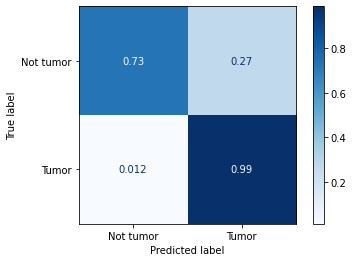

In [ ]:
# normalized
plot_confusion_matrix(clf, X_test_reshaped, df_labels_test.tumor, normalize = "true", cmap=plt.cm.Blues, display_labels=['Not tumor', 'Tumor'])  
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


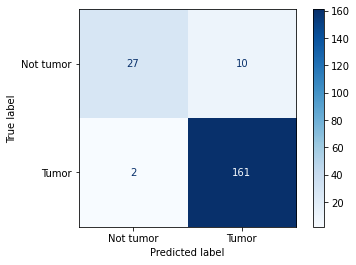

In [ ]:
plot_confusion_matrix(clf, X_test_reshaped, df_labels_test.tumor, cmap=plt.cm.Blues, values_format=".0f", display_labels=['Not tumor', 'Tumor'])  
plt.show()

### 3. Binary model

#### 3.1 CNN (from scratch)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1

acc_per_fold = []
loss_per_fold = []

 
for train, val in kfold.split(imgs_arr, labels):

  ## CNN 

  model = Sequential()
  model.add(Conv2D(64, (5,5), input_shape = (imgs_arr[0].shape[0], imgs_arr[0].shape[1], 3), padding = 'same'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size =  (2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (5,5), padding = 'same'))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size =  (2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, (3,3), padding = 'same'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size =  (2,2)))
  model.add(Dropout(0.2))


  model.add(Flatten())

  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  # Compile the model
  model.compile(loss=keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer='adam')


  
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')


  class_weights = class_weight.compute_class_weight(class_weight= 'balanced'
                                                 ,classes = np.unique(labels)
                                                 ,y= labels)
  
  computed_class_weights = dict(zip(np.unique(labels), class_weights))


  history = model.fit(imgs_arr[train], labels[train],
                      epochs = 20,
                      batch_size = 100,
                      #validation_data=(X_val,y_val),
                      class_weight = computed_class_weights,
                      verbose=1)


  scores = model.evaluate(imgs_arr[val], labels[val], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_no = fold_no + 1


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
24/24 [==============================] - 6s 227ms/step - loss: 0.5301 - accuracy: 0.7679
Epoch 2/20
24/24 [==============================] - 5s 225ms/step - loss: 0.3171 - accuracy: 0.8467
Epoch 3/20
24/24 [==============================] - 5s 226ms/step - loss: 0.2492 - accuracy: 0.8908
Epoch 4/20
24/24 [==============================] - 5s 227ms/step - loss: 0.2006 - accuracy: 0.9233
Epoch 5/20
24/24 [==============================] - 5s 227ms/step - loss: 0.1774 - accuracy: 0.9367
Epoch 6/20
24/24 [==============================] - 5s 225ms/step - loss: 0.1354 - accuracy: 0.9517
Epoch 7/20
24/24 [==============================] - 5s 227ms/step - loss: 0.1086 - accuracy: 0.9583
Epoch 8/20
24/24 [==============================] - 5s 227ms/step - loss: 0.0756 - accuracy: 0.9758
Epoch 9/20
24/24 [==============================] - 5s 227ms/step - loss: 0.0774 - accuracy: 0.9721
Epo

In [ ]:
print("%0.2f is the cross validation accuracy with 5 folds, with a standard deviation of %0.2f" % (np.mean(acc_per_fold), np.std(acc_per_fold)))

94.93 is the cross validation accuracy with 5 folds, with a standard deviation of 1.45


In [ ]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    #plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.xlabel("")
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    #plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


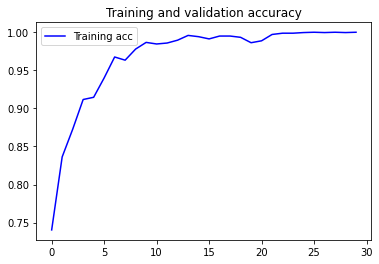

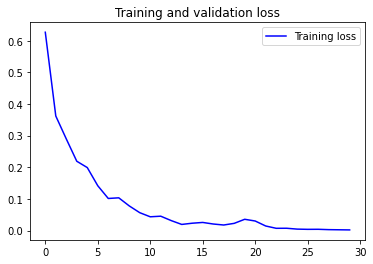

In [ ]:
# Run the function to illustrate accuracy and loss
visualize_results(history)

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(imgs_arr_test)
print(classification_report(labels_test, y_pred.round(), target_names=['No tumor', 'Tumor'], digits=4))

              precision    recall  f1-score   support

    No tumor     0.8293    0.9189    0.8718        37
       Tumor     0.9811    0.9571    0.9689       163

    accuracy                         0.9500       200
   macro avg     0.9052    0.9380    0.9204       200
weighted avg     0.9530    0.9500    0.9510       200



In [ ]:
# Not Normalized
cm = confusion_matrix(labels_test, y_pred.round())
print(cm)

[[ 34   3]
 [  7 156]]


In [ ]:
# Normalized
cm = confusion_matrix(labels_test, y_pred.round(), normalize='true')
print(cm)

[[0.91891892 0.08108108]
 [0.04294479 0.95705521]]


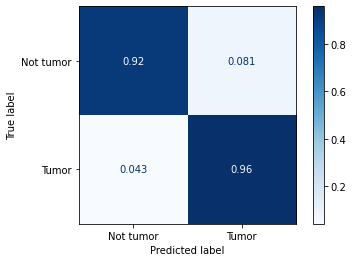

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not tumor', 'Tumor'])
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

#### 3.2 Fine-tuning

In [ ]:
from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50



kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1

acc_per_fold = []
loss_per_fold = []

 
for train, val in kfold.split(imgs_arr, labels):
  
  # load model and specify a new input shape for images
  input_tensor = Input(shape=(100, 100, 3))

  # creating the base model of pre-trained VGG16 model
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))


  # Freeze all the layers
  for layer in base_model.layers[:]:
      layer.trainable = False


  # build a classifier model to put on top of the convolutional model
  model = Sequential()
  model.add(base_model)
  model.add(Flatten(input_shape=base_model.output_shape[1:]))

  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))


  model.compile(loss=keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer='adam')

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  class_weights = class_weight.compute_class_weight(class_weight= 'balanced'
                                                 ,classes = np.unique(labels)
                                                 ,y= labels)

  computed_class_weights = dict(zip(np.unique(labels), class_weights))


  history = model.fit(imgs_arr[train], labels[train],
                      epochs = 30,
                      batch_size = 100,
                      #validation_data=(X_val,y_val),
                      class_weight = computed_class_weights,
                      verbose=1)  
  

  scores = model.evaluate(imgs_arr[val], labels[val], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_no = fold_no + 1


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
24/24 [==============================] - 6s 199ms/step - loss: 0.5378 - accuracy: 0.7042
Epoch 2/30
24/24 [==============================] - 5s 194ms/step - loss: 0.3592 - accuracy: 0.7979
Epoch 3/30
24/24 [==============================] - 5s 195ms/step - loss: 0.2693 - accuracy: 0.8496
Epoch 4/30
24/24 [==============================] - 5s 196ms/step - loss: 0.2320 - accuracy: 0.8967
Epoch 5/30
24/24 [==============================] - 5s 195ms/step - loss: 0.1743 - accuracy: 0.9171
Epoch 6/30
24/24 [==============================] - 5s 194ms/step - loss: 0.1482 - accuracy: 0.9321
Epoch 7/30
24/24 [==============================] - 5s 195ms/step - loss: 0.1313 - accuracy: 0.9463
Epoch 8/30
24/24 [==============================] - 5s 194ms/step - loss: 0.0946 - accuracy: 0.9613
Epoch 9/30
24/24 [==============================] - 5s 195ms/step - loss: 0.0940 - accuracy: 0.9583
Epo

In [ ]:
print("%0.2f is the cross validation accuracy with 5 folds, with a standard deviation of %0.2f" % (np.mean(acc_per_fold), np.std(acc_per_fold)))

96.90 is the cross validation accuracy with 5 folds, with a standard deviation of 1.01


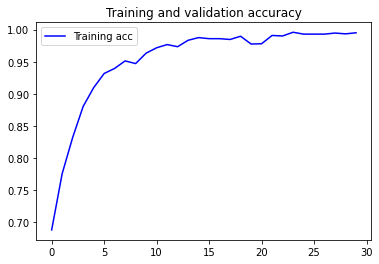

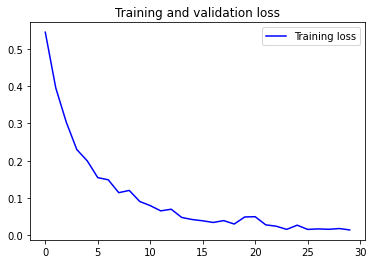

In [ ]:
# Run the function to illustrate accuracy and loss
visualize_results(history)

In [ ]:
y_pred = model.predict(imgs_arr_test)
print(classification_report(labels_test, y_pred.round(), target_names=['No tumor', 'Tumor'], digits=4))

              precision    recall  f1-score   support

    No tumor     0.9000    0.9730    0.9351        37
       Tumor     0.9938    0.9755    0.9845       163

    accuracy                         0.9750       200
   macro avg     0.9469    0.9742    0.9598       200
weighted avg     0.9764    0.9750    0.9754       200



In [ ]:
# Not Normalized
cm = confusion_matrix(labels_test, y_pred.round())
print(cm)

[[ 36   1]
 [  4 159]]


In [ ]:
# Normalized
cm = confusion_matrix(labels_test, y_pred.round(), normalize='true')
print(cm)

[[0.97297297 0.02702703]
 [0.02453988 0.97546012]]


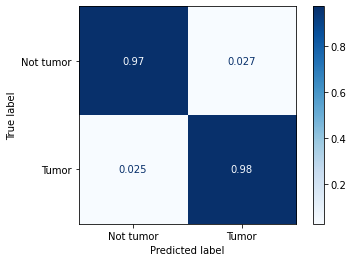

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not tumor', 'Tumor'])
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

#### 3.3 Fine-tuning with data augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications import ResNet50


kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1

acc_per_fold = []
loss_per_fold = []

X = df_labels.loc[:,'file_name']
y = df_labels.loc[:,'tumor']

 
for train, val in kfold.split(X, y):

  # prepare Train df
  df_train = pd.DataFrame(columns=['file_name','tumor'])
  df_train['file_name'] = X[train]
  df_train['tumor'] = y[train]
  df_train.reset_index(drop=True, inplace=True)


  # prepare Test df
  df_val= pd.DataFrame(columns=['file_name','tumor'])
  df_val['file_name'] = X[val]
  df_val['tumor'] = y[val]
  df_val.reset_index(drop=True, inplace=True)


  input_tensor = Input(shape=(100, 100, 3))
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))


    # Freeze all the layers
  for layer in base_model.layers[:]:
      layer.trainable = False


  # build a classifier model to put on top of the convolutional model
  model = Sequential()
  model.add(base_model)
  model.add(Flatten(input_shape=base_model.output_shape[1:]))

  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.05))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))


  class_weights = class_weight.compute_class_weight(class_weight= 'balanced', classes = np.unique(y[train]), y= y[train])
  computed_class_weights = dict(zip(np.unique(y[train]), class_weights))


  train_datagen = ImageDataGenerator(horizontal_flip=True,
                                     brightness_range=[0.5,1]
                                     )
  
  df_train['tumor'] = df_train['tumor'].astype('str')
  
  train_generator = train_datagen.flow_from_dataframe(dataframe=df_train, 
                                              directory='/content/drive/MyDrive/data/Brain/crop',
                                              x_col="file_name", 
                                              y_col="tumor",                          
                                              class_mode="binary", 
                                              target_size=(100, 100), 
                                              batch_size=100,
                                              rescale=1.0/255,
                                              #subset="training",
                                              seed=2020,
                                              shuffle=False)


  val_datagen = ImageDataGenerator()
  df_val['tumor'] = df_val['tumor'].astype('str')
  
  val_generator = val_datagen.flow_from_dataframe(dataframe=df_val, 
                                                   directory='/content/drive/MyDrive/data/Brain/crop',
                                                   x_col="file_name", 
                                                   y_col="tumor", 
                                                   class_mode="binary", 
                                                   target_size=(100, 100), 
                                                   batch_size=100,
                                                   rescale=1.0/255,
                                                   seed=2020,
                                                   shuffle=False)
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(train_generator, batch_size=100, epochs=20, class_weight = computed_class_weights, verbose=1)
  scores = model.evaluate(val_generator, verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_no = fold_no + 1

58900480/58889256 [==============================] - 2s 0us/step
Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
24/24 [==============================] - 28s 502ms/step - loss: 0.5259 - accuracy: 0.6938
Epoch 2/20
24/24 [==============================] - 14s 560ms/step - loss: 0.2920 - accuracy: 0.8338
Epoch 3/20
24/24 [==============================] - 14s 558ms/step - loss: 0.1969 - accuracy: 0.9083
Epoch 4/20
24/24 [==============================] - 13s 550ms/step - loss: 0.1568 - accuracy: 0.9383
Epoch 5/20
24/24 [==============================] - 14s 569ms/step - loss: 0.1132 - accuracy: 0.9575
Epoch 6/20
24/24 [==============================] - 13s 544ms/step - loss: 0.0785 - accuracy: 0.9675
Epoch 7/20
24/24 [==============================] - 13s 540ms/step - loss: 0.0577 - accuracy: 0.9821
Epoch 8/20

In [ ]:
print("%0.2f is the cross validation accuracy with 5 folds, with a standard deviation of %0.2f" % (np.mean(acc_per_fold), np.std(acc_per_fold)))

97.40 is the cross validation accuracy with 5 folds, with a standard deviation of 0.88


In [ ]:
test_datagen = ImageDataGenerator()
df_labels_test['tumor'] = df_labels_test['tumor'].astype('str')
  
test_generator = test_datagen.flow_from_dataframe(dataframe=df_labels_test, 
                                                directory='/content/drive/MyDrive/data/Brain/test_dataset/test/crop',
                                                x_col="file_name", 
                                                y_col="tumor", 
                                                class_mode="binary", 
                                                target_size=(100, 100), 
                                                batch_size=100,
                                                rescale=1.0/255,
                                                seed=2020,
                                                shuffle=False)

Found 200 validated image filenames belonging to 2 classes.


In [ ]:
y_pred = model.predict(test_generator, verbose=0)

In [ ]:
print(classification_report(labels_test, y_pred.round(), target_names=['No tumor', 'Tumor'], digits=4))

              precision    recall  f1-score   support

    No tumor     0.9474    0.9730    0.9600        37
       Tumor     0.9938    0.9877    0.9908       163

    accuracy                         0.9850       200
   macro avg     0.9706    0.9804    0.9754       200
weighted avg     0.9852    0.9850    0.9851       200



In [ ]:
# Not Normalized
cm = confusion_matrix(labels_test, y_pred.round())
print(cm)

[[ 36   1]
 [  2 161]]


In [ ]:
# Normalized
cm = confusion_matrix(labels_test, y_pred.round(), normalize = 'true')
print(cm)

[[0.97297297 0.02702703]
 [0.01226994 0.98773006]]


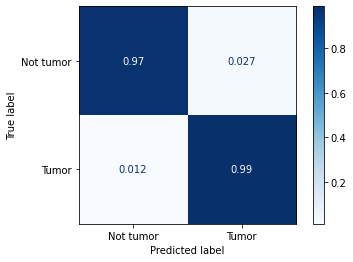

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not tumor', 'Tumor'])
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
model.save("tumor_classification.h5")
print("Saved model to disk")

### 4.  Multi-label

In [ ]:
from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications import ResNet50


kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1

acc_per_fold = []
loss_per_fold = []

X = df_labels.loc[:,'file_name']
y = df_labels.loc[:,'tumor_type']

 
for train, val in kfold.split(X, y):

  # prepare Train df
  df_train = pd.DataFrame(columns=['file_name','tumor_type'])
  df_train['file_name'] = X[train]
  df_train['tumor_type'] = y[train]
  df_train.reset_index(drop=True, inplace=True)


  # prepare val df
  df_val= pd.DataFrame(columns=['file_name','tumor_type'])
  df_val['file_name'] = X[val]
  df_val['tumor_type'] = y[val]
  df_val.reset_index(drop=True, inplace=True)


  input_tensor = Input(shape=(100, 100, 3))
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))


    # Freeze all the layers
  for layer in base_model.layers[:]:
      layer.trainable = False

  model = Sequential()
  model.add(base_model)

  model.add(Flatten(input_shape=base_model.output_shape[1:]))

  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))


  class_weights = class_weight.compute_class_weight(class_weight= 'balanced', classes = np.unique(y[train]), y= y[train])
  computed_class_weights = dict(zip(np.unique(y[train]), class_weights))


  train_datagen = ImageDataGenerator(horizontal_flip=True,
                                     brightness_range=[0.5,1]
                                     )
  
  df_train['tumor_type'] = df_train['tumor_type'].astype('str')
  
  train_generator = train_datagen.flow_from_dataframe(dataframe=df_train, 
                                              directory='/content/drive/MyDrive/data/Brain/crop',
                                              x_col="file_name", 
                                              y_col="tumor_type",                          
                                              class_mode="sparse", 
                                              target_size=(100, 100), 
                                              batch_size=100,
                                              rescale=1.0/255,
                                              #subset="training",
                                              seed=2020,
                                              shuffle=False)


  val_datagen = ImageDataGenerator()
  df_val['tumor_type'] = df_val['tumor_type'].astype('str')
  
  val_generator = val_datagen.flow_from_dataframe(dataframe=df_val, 
                                                   directory='/content/drive/MyDrive/data/Brain/crop',
                                                   x_col="file_name", 
                                                   y_col="tumor_type", 
                                                   class_mode="sparse", 
                                                   target_size=(100, 100), 
                                                   batch_size=100,
                                                   rescale=1.0/255,
                                                   seed=2020,
                                                   shuffle=False)
  
  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])


  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(train_generator, batch_size=100, epochs=20, class_weight = computed_class_weights, verbose=1)


  for layer in model.submodules:
      layer.trainable = True

  initial_learning_rate = 1e-5
  
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
     initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
  )

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
  
  history = model.fit(train_generator, batch_size=100, epochs=5, class_weight = computed_class_weights, verbose=1)


  scores = model.evaluate(val_generator)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_no = fold_no + 1

Found 2400 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
24/24 [==============================] - 16s 608ms/step - loss: 1.1987 - accuracy: 0.5875
Epoch 2/20
24/24 [==============================] - 13s 542ms/step - loss: 0.6650 - accuracy: 0.7575
Epoch 3/20
24/24 [==============================] - 13s 553ms/step - loss: 0.5085 - accuracy: 0.8112
Epoch 4/20
24/24 [==============================] - 14s 561ms/step - loss: 0.3830 - accuracy: 0.8508
Epoch 5/20
24/24 [==============================] - 14s 563ms/step - loss: 0.3271 - accuracy: 0.8725
Epoch 6/20
24/24 [==============================] - 13s 552ms/step - loss: 0.2912 - accuracy: 0.8875
Epoch 7/20
24/24 [==============================] - 13s 551ms/step - loss: 0.2110 - accuracy: 0.9196
Epoch 8/20
24/24 [==============================] - 14s 558ms/step - loss: 

In [ ]:
print("%0.2f is the cross validation accuracy with 5 folds, with a standard deviation of %0.2f" % (np.mean(acc_per_fold), np.std(acc_per_fold)))

90.70 is the cross validation accuracy with 5 folds, with a standard deviation of 0.71


In [ ]:

test_datagen = ImageDataGenerator()
df_labels_test['tumor_type'] = df_labels_test['tumor_type'].astype('str')
  
test_generator = test_datagen.flow_from_dataframe(dataframe=df_labels_test, 
                                                directory='/content/drive/MyDrive/data/Brain/test_dataset/test/crop',
                                                x_col="file_name", 
                                                y_col="tumor_type", 
                                                class_mode="sparse", 
                                                target_size=(100, 100), 
                                                batch_size=100,
                                                rescale=1.0/255,
                                                seed=2020,
                                                shuffle=False)


Found 200 validated image filenames belonging to 4 classes.


In [ ]:
y_pred = model.predict(test_generator, verbose=0)

In [ ]:
#y_pred = model.predict(X_test)
pred  = np.argmax(y_pred, axis = -1)
target_names =  ['No tumor', 'meningioma','glioma', 'pituitary']
print(classification_report(pd.to_numeric(df_labels_test.tumor_type), pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

    No tumor     0.9459    0.9459    0.9459        37
  meningioma     0.9206    0.8529    0.8855        68
      glioma     0.8372    0.8372    0.8372        43
   pituitary     0.8772    0.9615    0.9174        52

    accuracy                         0.8950       200
   macro avg     0.8952    0.8994    0.8965       200
weighted avg     0.8961    0.8950    0.8946       200



In [ ]:
# Not Normalized
cm = confusion_matrix(pd.to_numeric(df_labels_test.tumor_type), pred.round())
print(cm)

[[35  0  2  0]
 [ 0 58  3  7]
 [ 2  5 36  0]
 [ 0  0  2 50]]


In [ ]:
# Normalized
cm = confusion_matrix(pd.to_numeric(df_labels_test.tumor_type), pred.round(), normalize = 'true')
print(cm)

[[0.94594595 0.         0.05405405 0.        ]
 [0.         0.85294118 0.04411765 0.10294118]
 [0.04651163 0.11627907 0.8372093  0.        ]
 [0.         0.         0.03846154 0.96153846]]


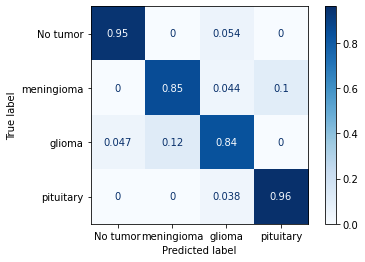

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()